In [3]:
from ucimlrepo import fetch_ucirepo 
heart_disease = fetch_ucirepo(id=45)  
X = heart_disease.data.features 
y = heart_disease.data.targets 

Data types check:

In [4]:
X.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object

In [5]:
y.dtypes

num    int64
dtype: object

Variables aren't correctly read

In [6]:
for i in [1,2,5,6,8,10,12]:
  X[X.columns[i]]=X[X.columns[i]].astype("category")

C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\2436755080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[X.columns[i]]=X[X.columns[i]].astype("category")


In [7]:
X.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
dtype: object

Initially the data presents a scale of how strong is the diseas (1, 2, 3, 4). As stated in the data repository the aim is to only detect the presence of the disease, hence the target variable needs to be converted into a binary (1,0). 

In [8]:
import pandas as pd
for i in range(len(y["num"])):
  if y["num"][i] in [1,2,3,4]:
    y["num"][i]=1
  else:
    y["num"][i]=0

C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\3726673565.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  y["num"][i]=0
C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\3726673565.py:6: SettingWithCopyWarning: 
A value is trying to b

In [9]:
y["num"].value_counts()

num
0    164
1    139
Name: count, dtype: int64

Target Variable Study

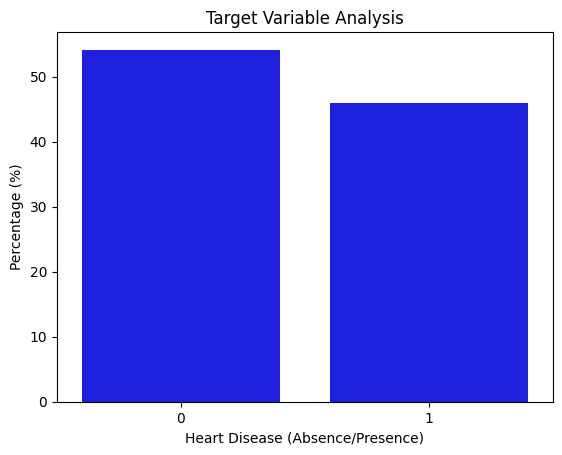

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

percentages = (y["num"].value_counts() * 100) / len(y)
sns.barplot(x=percentages.index, y=percentages.values, color="b")

plt.title("Target Variable Analysis")
plt.xlabel("Heart Disease (Absence/Presence)")
plt.ylabel("Percentage (%)")
plt.show()

In [11]:
round(((y["num"].value_counts() * 100) / len(y)),3)

num
0    54.125
1    45.875
Name: count, dtype: float64

The target isn't unbalanced

Categorical Variables Study

In [37]:
cat=X.select_dtypes(include="category")
cat.dtypes

sex        category
cp         category
fbs        category
restecg    category
exang      category
slope      category
thal       category
dtype: object

In [38]:
round((y[y["num"] == 1].value_counts()*100)/len(y),3)

num
1      45.875
Name: count, dtype: float64

C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\4115056533.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ((y[y["num"] == 1].groupby(cat[column]).size() * 100) / (cat.groupby(cat[column]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\4115056533.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ((y[y["num"] == 1].groupby(cat[column]).size() * 100) / (cat.groupby(cat[column]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\4115056533.py:12: FutureWarning: The default of observed=False is 

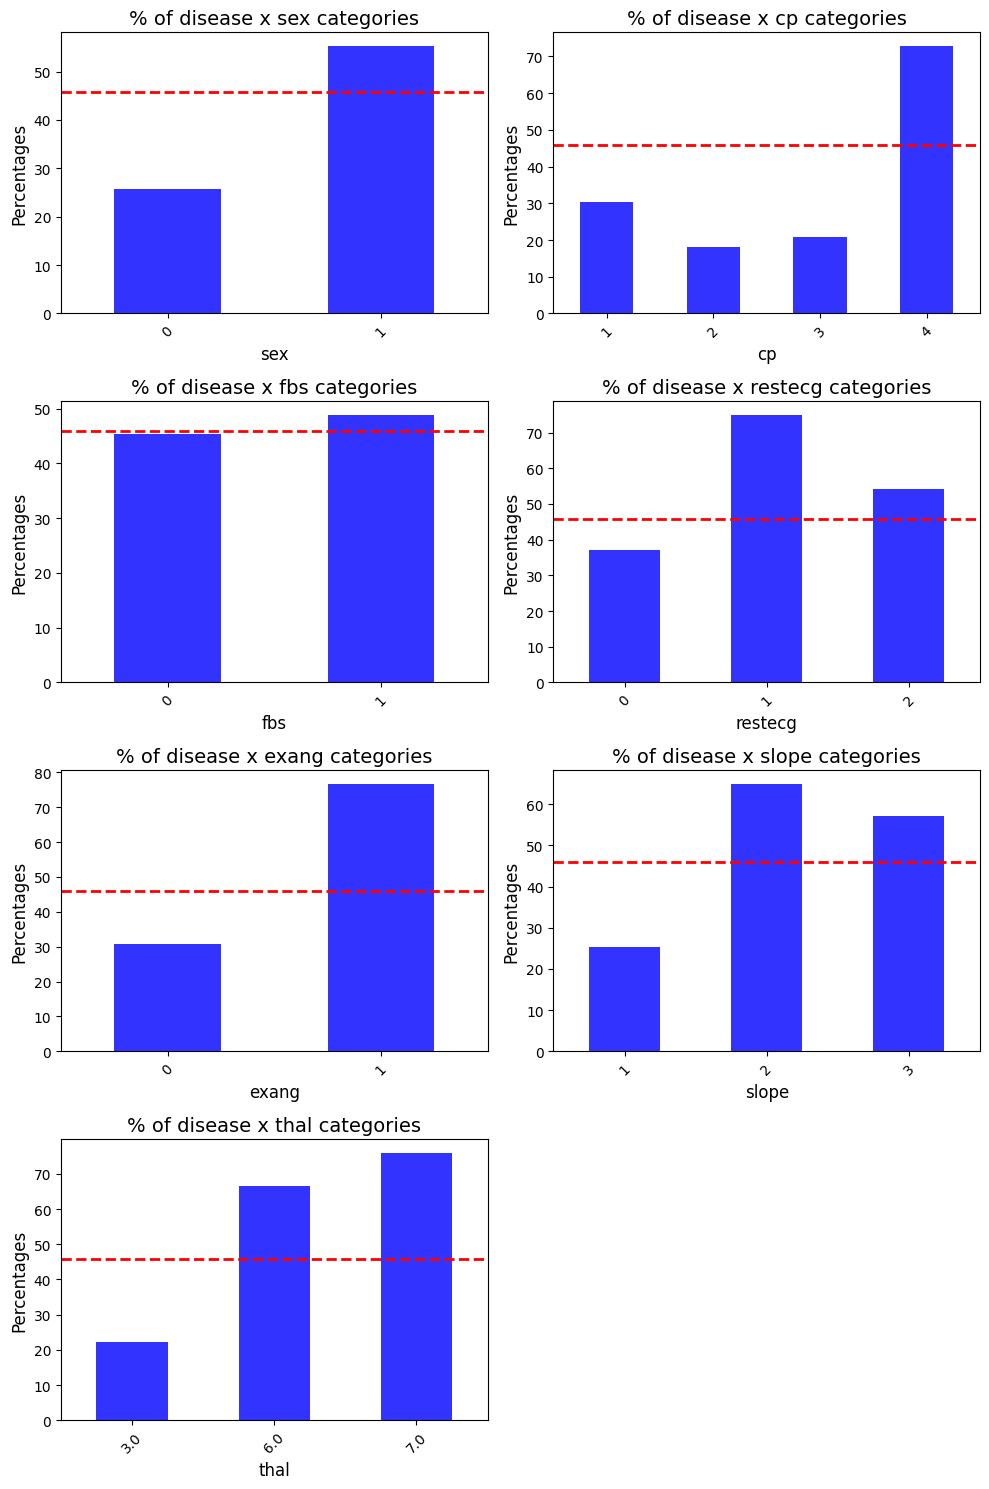

In [43]:
import matplotlib.pyplot as plt
import numpy as np

colplot = cat.columns

fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()

for i, column in enumerate(colplot):
    ax = axes[i]
    
    ((y[y["num"] == 1].groupby(cat[column]).size() * 100) / (cat.groupby(cat[column]).size())).plot(kind="bar",color="b", alpha=0.8, ax=ax)
    ax.axhline(y=45.875, color="r", linestyle="--", linewidth=2, label="Threshold 45.875")

    
    ax.set_title(f"% of disease x {column} categories", fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Percentages", fontsize=12)
    ax.tick_params(axis="x", rotation=45)

 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  

plt.tight_layout()
plt.show()

Based on the bar analysis all the variables should  be explicative of the target, with the exception of "fbs". To be sure about this a Chi-Square test is performed. 

In [50]:
from scipy.stats import chi2_contingency

y["num"]=y["num"].astype("category")
contingency_table = pd.crosstab(cat["sex"],y["num"])
p= chi2_contingency(contingency_table)
print(f"P-value: {p}")

Chi2 statistic: 22.042560606155472
Degrees of Freedom: 1
Expected frequencies: 
[[ 52.50165017  44.49834983]
 [111.49834983  94.50165017]]
P-value: 2.666712348180942e-06


C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\3974064368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["num"]=y["num"].astype("category")


In [56]:
import pandas as pd
from scipy.stats import chi2_contingency

y["num"] = y["num"].astype("category")

p_values = []

for column in cat.columns:
    contingency_table = pd.crosstab(cat[column], y["num"])
    chi2, p, dof, expected= chi2_contingency(contingency_table)
    p_values.append(p)

p_values_df = pd.DataFrame(p_values, index=cat.columns, columns=["p-value"])
print(p_values_df)

              p-value
sex      2.666712e-06
cp       1.251711e-17
fbs      7.812734e-01
restecg  6.566524e-03
exang    1.413788e-13
slope    1.142885e-10
thal     8.201820e-19


C:\Users\giovi\AppData\Local\Temp\ipykernel_11744\37840438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["num"] = y["num"].astype("category")


Chi-Square confirms what was seen in the previous charts. "fbs" has a p-value>0.05, this means there isn't a significant relation with the target variable.

Numeric Variables Analysis

In [69]:
num=X.select_dtypes("number")
num.dtypes

age           int64
trestbps      int64
chol          int64
thalach       int64
oldpeak     float64
ca          float64
dtype: object

In [71]:
num["num"] = y["num"].astype("int64") 
corr=num.corr()
corr.style.background_gradient(cmap="coolwarm")

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.362605,0.223120
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.098773,0.150825
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.119000,0.085164
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.264246,-0.417167
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.295832,0.424510
ca,0.362605,0.098773,0.119000,-0.264246,0.295832,1.000000,0.460442
num,0.223120,0.150825,0.085164,-0.417167,0.424510,0.460442,1.000000


Prima di fare scelte effettuiamo una regressione logistica.